In [1]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import mne
from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_gdf
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from EEGModels import EEGNet
from sklearn.metrics import confusion_matrix


'''
Parameters:
'''
tmin = 0
tmax = 10

In [2]:
object_names = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06']
# object_names = ['P01', 'P02', 'P03', 'P04']
files = []
for name in object_names:
    for i in range(15):
        files.append(read_raw_gdf(f'..\\{name}\\{name} Run {i+1}.gdf', stim_channel=None, eog=[61,62,63]))

Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 1.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 2.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 3.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from D:\EEGTest\Attempted arm and hand movements in persons with spinal cord injury\P01\P01 Run 5.gdf...
GDF file dete

C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
C:\Users\kings\Anaconda3\envs\mne\lib\site-packages\mne\io\edf\edf.py:996: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

In [3]:
print(len(files))

90


In [21]:
eventDescription_offline_paradigm = {
    '768': "trial start",
    '785': "beep",
    '786': "fixation cross",
    '776': "supinationclass cue",
    '777': "pronationclass cue",
    '779': "hand openclass cue",
    '925': "palmar graspclass cue",
    '926': "ateral graspclass cue",
}
# narrow it down to two
eventDescription_offline_paradigm = {
    '776': "supinationclass cue",
    '777': "pronationclass cue",
}

In [22]:
# events = [number of events, position, event code, channel, duration]
# file_P01_Run3._raw_extras[0]['events']
event_id = {}
epochs_list = []
for file in files:
    event, _ = mne.events_from_annotations(file)


    # build event id and filter 1-7 id

    contains_both = 0
    for i in _: #handle event_id
        if i not in eventDescription_offline_paradigm:
            continue
        contains_both += 1
        event_id[eventDescription_offline_paradigm[i]] = _[i]


    print(f'event id: {event_id}')
    if contains_both == len(eventDescription_offline_paradigm):
        epochs = mne.Epochs(file, event, event_id, tmin=-0., tmax=1, baseline=None, event_repeated = 'merge', preload=True)

        epochs_list.append(epochs)

result_epochs = mne.concatenate_epochs(epochs_list)

Used Annotations descriptions: ['33536', '768', '785']
event id: {}
Used Annotations descriptions: ['33536', '33554', '768', '785', '786']
event id: {}
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'supinationclass cue': 9, 'pronationclass cue': 10}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['33536', '33544', '33545', '33547', '33554', '33693', '33694', '768', '776', '777', '779', '785', '786', '925', '926']
event id: {'supinationclass cue': 9, 'pronationclass cue': 10}
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Loading data for 16 events and 257 original time points ...
0 bad epochs dropped
Used

In [23]:
print(len(set(event_id)))
#9, 10, 0
print(result_epochs.events)

2
[[   3072       0      10]
 [   6945       0       9]
 [  10769       0       9]
 ...
 [3991213       0      10]
 [3995000       0       9]
 [3996598       0       9]]


In [24]:
# 0: not supinationclass or pronationclass cue
labels = result_epochs.events[:,-1]
# labels = np.array(list(map(lambda x:  0 if (not x == 9) else x, labels)))
print(labels)

# format: trials, channels, samples
X = result_epochs.get_data() * 1000
y = labels

kernels, chans, samples = 1, 64, 257

[10  9  9 10 10  9  9 10 10 10 10  9  9  9  9 10 10 10 10  9  9  9 10  9
 10  9  9 10  9 10  9 10 10 10 10  9  9  9 10  9 10 10  9  9  9 10  9 10
 10 10  9  9  9 10 10  9  9 10 10  9  9  9 10 10  9 10 10  9 10  9  9  9
 10 10  9 10 10  9  9 10 10 10  9 10  9 10  9  9  9 10 10  9  9 10  9 10
 10 10 10 10  9  9  9  9  9 10 10  9 10  9  9 10 10  9 10 10  9 10  9 10
 10  9 10  9  9  9  9 10 10  9 10 10 10  9 10  9  9 10  9 10  9 10  9  9
  9 10 10  9 10  9  9  9 10 10  9 10 10  9  9 10 10 10  9 10  9 10  9  9
  9 10 10  9  9 10  9 10 10 10 10 10  9  9  9  9  9 10 10  9 10  9  9 10
 10  9 10 10  9 10  9 10 10  9 10  9  9  9  9 10 10  9 10 10 10  9 10  9
  9 10  9 10  9 10  9  9  9 10  9 10 10 10  9  9 10 10  9  9  9 10 10  9
  9  9 10 10 10 10 10 10  9  9 10 10  9  9  9  9  9 10 10  9 10 10  9  9
 10  9  9 10 10  9 10  9 10 10  9  9 10  9  9 10 10  9  9 10 10  9  9 10
 10 10 10  9  9  9 10  9 10  9  9 10  9 10  9 10 10 10 10  9  9  9 10  9
 10 10  9  9  9 10  9 10 10 10  9  9  9 10 10  9  9

In [25]:
X.shape

(864, 64, 257)

In [29]:
# Spliting dataset
# 70% Training, 10% Validate, 20% Testing
X_train = X[0:604,]
Y_train = y[0:604]
X_validate = X[604:691,]
Y_validate = y[604:691]
X_test = X[691:,]
Y_test = y[691:]

print(Y_train)

[10  9  9 10 10  9  9 10 10 10 10  9  9  9  9 10 10 10 10  9  9  9 10  9
 10  9  9 10  9 10  9 10 10 10 10  9  9  9 10  9 10 10  9  9  9 10  9 10
 10 10  9  9  9 10 10  9  9 10 10  9  9  9 10 10  9 10 10  9 10  9  9  9
 10 10  9 10 10  9  9 10 10 10  9 10  9 10  9  9  9 10 10  9  9 10  9 10
 10 10 10 10  9  9  9  9  9 10 10  9 10  9  9 10 10  9 10 10  9 10  9 10
 10  9 10  9  9  9  9 10 10  9 10 10 10  9 10  9  9 10  9 10  9 10  9  9
  9 10 10  9 10  9  9  9 10 10  9 10 10  9  9 10 10 10  9 10  9 10  9  9
  9 10 10  9  9 10  9 10 10 10 10 10  9  9  9  9  9 10 10  9 10  9  9 10
 10  9 10 10  9 10  9 10 10  9 10  9  9  9  9 10 10  9 10 10 10  9 10  9
  9 10  9 10  9 10  9  9  9 10  9 10 10 10  9  9 10 10  9  9  9 10 10  9
  9  9 10 10 10 10 10 10  9  9 10 10  9  9  9  9  9 10 10  9 10 10  9  9
 10  9  9 10 10  9 10  9 10 10  9  9 10  9  9 10 10  9  9 10 10  9  9 10
 10 10 10  9  9  9 10  9 10  9  9 10  9 10  9 10 10 10 10  9  9  9 10  9
 10 10  9  9  9 10  9 10 10 10  9  9  9 10 10  9  9

In [30]:
# Label Encode it first
encoder = LabelEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train)
Y_validate = encoder.transform(Y_validate)
Y_test = encoder.transform(Y_test)

# Convert label to one-hot encodings
Y_train = np_utils.to_categorical(Y_train)
Y_validate = np_utils.to_categorical(Y_validate)
Y_test = np_utils.to_categorical(Y_test)

#convert to (trials, kernels, channels, samples) format.
# contains 64 channels and 257 time-points. Set the number of kernels to 1.
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_validate = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (604, 1, 64, 257)
604 train samples
173 test samples


In [31]:
# testing gpu
from tensorflow.python.client import device_lib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
for physical_device in gpus:
    tf.config.experimental.set_memory_growth(physical_device, True)
# change the memory fraction as you want...import tensorflow as tf
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
print(gpus)

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
# configure the EEGNet-8,2,16 model with kernel length of 257 samples (other
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples,
               dropoutRate = 0.5, kernLength = 128, F1 = 8, D = 2, F2 = 16)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 64, 257)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 64, 257)        1024      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 64, 257)        32        
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 16, 1, 257)        1024      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 1, 257)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 16, 1, 257)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 1, 64)        

In [33]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='./checkpoint.h5', verbose=1,
                               save_best_only=True)


In [34]:
# add callback
losses = []
accs = []
class LossAndAccRecord(Callback):
    def on_batch_end(self, batch, logs=None):
        losses.append(logs["loss"])
        accs.append(logs["accuracy"])


    def on_epoch_end(self, epoch, logs=None):
        pass


In [35]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# unused
class_weights = {0:1, 1:1, 2:1, 3:1}
with tf.device('/device:GPU:0'):
    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 20,
                        verbose = 1, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer, LossAndAccRecord()])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.4901
Epoch 00001: val_loss improved from inf to 0.69578, saving model to .\checkpoint.h5
38/38 [==============================] - 1s 13ms/step - loss: 0.7251 - accuracy: 0.4901 - val_loss: 0.6958 - val_accuracy: 0.4713
Epoch 2/20
31/38 [=======================>......] - ETA: 0s - loss: 0.6941 - accuracy: 0.5202

In [36]:
# load optimal weights
model.load_weights('./checkpoint.h5')

In [37]:
###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
print(probs)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %.4f " % (acc))

[[0.47542036 0.52457964]
 [0.50987035 0.49012965]
 [0.5415266  0.45847335]
 [0.54287064 0.4571293 ]
 [0.5320464  0.4679536 ]
 [0.4727853  0.5272147 ]
 [0.5530682  0.44693178]
 [0.53816605 0.46183395]
 [0.49331403 0.506686  ]
 [0.46899515 0.5310048 ]
 [0.45409843 0.5459016 ]
 [0.42882147 0.57117856]
 [0.53395003 0.46604994]
 [0.4813352  0.5186648 ]
 [0.51971465 0.48028535]
 [0.54098296 0.45901704]
 [0.43231905 0.56768095]
 [0.413944   0.58605593]
 [0.4761514  0.5238486 ]
 [0.4774255  0.52257454]
 [0.51021636 0.48978367]
 [0.4567854  0.5432146 ]
 [0.46610424 0.53389573]
 [0.48739856 0.51260144]
 [0.50896555 0.49103445]
 [0.54312366 0.45687637]
 [0.47313094 0.52686906]
 [0.47503483 0.52496517]
 [0.51488864 0.48511136]
 [0.43217698 0.567823  ]
 [0.484118   0.515882  ]
 [0.5041712  0.49582878]
 [0.47537372 0.5246263 ]
 [0.3876871  0.6123129 ]
 [0.44803953 0.55196047]
 [0.49229115 0.50770885]
 [0.4833891  0.5166109 ]
 [0.48564962 0.5143504 ]
 [0.39675677 0.60324323]
 [0.38624516 0.6137548 ]


In [38]:
confusion_matrix(Y_test.argmax(axis=-1), preds)

array([[31, 56],
       [23, 63]], dtype=int64)

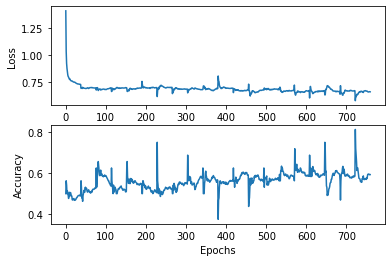

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(accs)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()